# Self-Organizing-Map (SOM)

1. Initialisation
   * Weights of neurons in the map layer are initialised.

2. Competitive process
   * Select one input sample and search the best matching unit among all neurons in n x m grid using distance measures.

3. Cooperative process
   * Find the proximity neurons of BMU by neighbourhood function.

4. Adaptation process
   * Update the BMU and neighbours' weights by shifting the values towards the input pattern.   If the maximum count of training iteration is reached, exit. If not, increment the iteration count by 1 and repeat the process from 2.

### 1. Import libraries

In [11]:
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance #distance calculation
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score #scoring
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors

### 2. Import dataset

The CSV file is downloaded from the website and stored in a directory. We use the first 4 columns for x and the last column as y.

In [12]:
data_file = "data_banknote_authentication.txt"
data_x = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=range(0,4) ,dtype=np.float64)
data_y = np.loadtxt(data_file, delimiter=",", skiprows=0, usecols=(4,),dtype=np.int64)

### 3. Training and testing data split

The data is split for training and testing at 0.8:0.2. We can see there are 1097 and 275 observations, respectively.

In [13]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(1097, 4) (1097,) (275, 4) (275,)


### 4. Helper functions

* **minmax_scaler** is used to normalise the input data between 0 and 1. Because the algorithm calculates the distance, we should scale the values of each feature to the same range to avoid any of them having a greater impact on the distance calculation than other features.

* **e_distance** calculates the Euclidean distance between the two points. 

* **m_distance** is for obtaining the Manhattan distance between two points on the grid. In our example, the Euclidean distance is used to search for the winning neuron while the Manhattan distance is used to limit the neighbourhood range. It simplifies the computation by applying the rectangular neighbourhood function where the neurons located within a certain Manhattan distance from the topological location of the BMU are activated at the same level.

* **winning_neuron** searches the BMU for the sample data t. The distance between the input signal and every neuron in the map layer is calculated and the row and column index of the grid of the neuron with the shortest distance is returned.

* **decay** returns learning rate and neighbourhood range after applying linear decay using the current training step, the maximum number of training steps and maximum neighbourhood range and learning rate.

In [14]:
# Helper functions

# Data Normalisation
def minmax_scaler(data):
  scaler = MinMaxScaler()
  scaled = scaler.fit_transform(data)
  return scaled

# Euclidean distance
def e_distance(x,y):
  return distance.euclidean(x,y)

# Manhattan distance
def m_distance(x,y):
  return distance.cityblock(x,y)

# Best Matching Unit search
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

# Learning rate and neighbourhood range calculation
def decay(step, max_steps, max_learning_rate, max_m_dsitance):
  coefficient = 1.0 - (np.float64(step) / max_steps)
  learning_rate = coefficient * max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_dsitance)
  return learning_rate, neighbourhood_range

### 5. Hyperparameters

Hyperparameters are non-trainable parameters that need to be selected before training algorithms. They are the number of neurons, the dimension of the SOM grid, the number of training steps, the learning rate and the neighbourhood range from the BMU.

In this example, we set the smaller numbers for the grid (10 * 10) but there are heuristics for the hyperparameter selections. We could use the ${5 * \sqrt{number\ of\ training\ samples}}$  to select the number of neurons. We have 1097 training samples, so ${5 * \sqrt{1097} = 165.60}$ neurons can be created on the grid. Because we have a 2D square lattice, the square root of the number suggests how many neurons we can have for each dimension. The ceiling of ${\sqrt{165.40} = 13}$, so the map’s dimensions can be 13 by 13.

The number of training steps may require at least ${500 * n\ rows * m\ columns}$ to converge. We can set the number of steps to be ${500 * 13 * 13 = 84500}$ to start with. The learning rate and neighbourhood ranges can be set at large numbers and gradually reduced. It is recommended to experiment with different sets of hyperparameters for improvements.

The initial value for the maximum neighbourhood range and learning rate can be set with a large number. If the rates are too small, it may result in overfitting and requiring more training steps for the learning.

In [15]:
# hyperparameters
num_nurons = 5 * np.sqrt(train_x.shape[0])
grid_size = int(ceil(np.sqrt(num_nurons)))
print(grid_size)

num_rows = grid_size
num_cols = grid_size
max_m_dsitance = 4
max_learning_rate = 0.5
max_steps = int(500 * grid_size * grid_size)

13


### 6. Training

After applying the input data normalisation, we initialise the map with random values between 0 and 1 for each neuron on the lattice. Then the learning rate and the neighbouring range are calculated using the decay function. A sample input observation is randomly selected from the training data and the best matching unit is searched. Based on the Manhattan distance criterion, the neighbours including the winner are selected for learning and weights are adjusted.

In [16]:
#mian function

train_x_norm = minmax_scaler(train_x) # normalisation

# initialising self-organising map
num_dims = train_x_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction
print(np.shape(som))

# start training iterations
for step in range(max_steps):
    if (step+1) % 1000 == 0:
        print("Iteration: ", step+1) # print out the current iteration for every 1k
    learning_rate, neighbourhood_range = decay(step, max_steps, max_learning_rate, max_m_dsitance)

    training_index = np.random.randint(0, high=train_x_norm.shape[0]) # random index of traing data
    winner = winning_neuron(train_x_norm, training_index, som, num_rows, num_cols)
    for row in range(num_rows):
        for col in range(num_cols):
            dist = m_distance([row, col], winner)
            if dist <= neighbourhood_range:
                som[row][col] += learning_rate * (((neighbourhood_range + 1) - dist) / neighbourhood_range + 1) * (train_x_norm[training_index] - som[row][col])
            else:
                som[row][col] -= (learning_rate / np.sqrt(grid_size)) * ((dist - neighbourhood_range) / (num_nurons * num_dims)) * (train_x_norm[training_index] - som[row][col]) 

print("SOM training completed")

(13, 13, 4)


Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
Iteration:  33000
Iteration:  34000
Iteration:  35000
Iteration:  36000
Iteration:  37000
Iteration:  38000
Iteration:  39000
Iteration:  40000
Iteration:  41000
Iteration:  42000
Iteration:  43000
Iteration:  44000
Iteration:  45000
Iteration:  46000
Iteration:  47000
Iteration:  48000
Iteration:  49000
Iteration:  50000
Iteration:  51000
Iteration:  52000
Iteration:  53000
Iteration:  54000
Iteration:  55000
Iteration:  56000
I

### 7. Show labels to the trained SOM

In the previous step, we completed the training. Because it is unsupervised learning but there is a label data for our problem, we can now project the labels to the map. This step has two parts. Firstly, the labels for each neuron are collected. Secondly, the single label is projected to each neuron to construct a label map.

In [17]:
# collecting labels

label_data = train_y
map = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        map[row][col] = [] # empty list to store the label

for t in range(train_x_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(train_x_norm, t, som, num_rows, num_cols)
    map[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron



sample data:  1000


We create the same grid as the SOM. For each training data, we search the winning neuron and add the label of the observation to the list for each BMU.

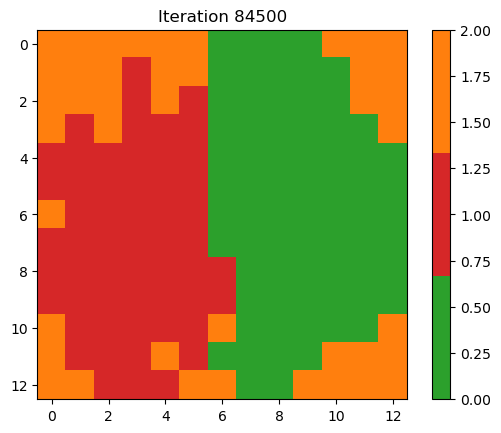

In [18]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
    for col in range(num_cols):
        label_list = map[row][col]
        if len(label_list)==0:
            label = 2
        else:
            label = max(label_list, key=label_list.count)
        label_map[row][col] = label

title = ('Iteration ' + str(max_steps))
cmap = colors.ListedColormap(['tab:green', 'tab:red', 'tab:orange'])
plt.imshow(label_map, cmap=cmap)
plt.colorbar()
plt.title(title)
plt.show()

To construct a label map, we assign a single label to each neuron on the map by majority voting. In the case of a neuron where no BMU is selected, we assigned the class value 2 as unidentifiable. Figures 3–7–1 and 3–7–2 show the created label map for the 1st and the final iteration. In the beginning, many of the neurons are neither 0 nor 1 and the class labels appear to be scattered randomly; the final iteration clearly shows the region separation between the class 0 and 1 though we see a couple of cells that do not belong to either class at the final iteration.

### 8. Predicting the test set labels

Finally, we can conduct a binary classification of the test data using the trained map. We normalise the test x data and search the MBU for each observation t. The label associated with the neuron is returned. 

In [19]:
# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = minmax_scaler(test_x) # normalisation

winner_labels = []

for t in range(data.shape[0]):
    winner = winning_neuron(data, t, som, num_rows, num_cols)
    row = winner[0]
    col = winner[1]
    predicted = label_map[row][col]
    winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(test_y, np.array(winner_labels)))

Accuracy:  0.9745454545454545
